# Simulating and Estimating a Multinomial Logit Model with SciPy

(some motivation to come later)

In [1]:
import numpy as np
from scipy import optimize as opt

In [54]:
# Model Primitives
np.random.seed(1234567890)

nObs = 10000
beta1 = [0.5, 1.25]
beta2 = [-0.4, 0.25]
beta = np.column_stack((beta1, beta2))
income= np.random.uniform(size = nObs) # draws from standard normal
explVar = np.column_stack((np.ones(nObs), income))

In [55]:
beta

array([[ 0.5 , -0.4 ],
       [ 1.25,  0.25]])

In [56]:
def simulateMultinomialLogit(x, beta):
    nObs, nExplVar = x.shape
    nChoice  = beta.shape[1] + 1 # add the outside option
    
    epsilon = np.random.gumbel(size = [nObs, nChoice])
    beta_augmented = np.column_stack([np.zeros(beta.shape[0]), beta])
    utility = x @ beta_augmented + epsilon
    choice = np.argmax(utility, axis=1)
    return  choice, utility

In [57]:
choice, utility = simulateMultinomialLogit(explVar, beta)

## Plot Choices in a 2D diagram

In [58]:
import matplotlib.pyplot as plt

In [59]:
%matplotlib inline

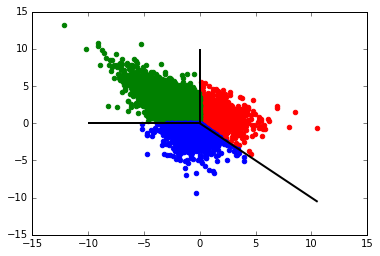

In [60]:
fig, ax = plt.subplots()
ax.scatter(utility[(choice==0), 0] - utility[(choice==0), 1], utility[(choice==0), 1] - utility[(choice==0), 2], color='r')
ax.scatter(utility[(choice==1), 0] - utility[(choice==1), 1], utility[(choice==1), 1] - utility[(choice==1), 2], color='g')
ax.scatter(utility[(choice==2), 0] - utility[(choice==2), 1], utility[(choice==2), 1] - utility[(choice==2), 2], color='b')
plt.vlines(x=min(utility[(choice==0), 0] - utility[(choice==0), 1]), ymin=0, ymax=10, color='k', lw=2.0 )
plt.hlines(y=min(utility[(choice==0), 0] - utility[(choice==0), 2]), xmin=-10, xmax=0, color='k', lw=2.0)
plt.plot([0, max(utility[(choice==0), 0] - utility[(choice==0), 1])], 
         [0,-max(utility[(choice==0), 0] - utility[(choice==0), 1])], color='k', lw=2.0)


In [61]:
# beta_g1 = [1, 2]
# beta_g2 = [3, 4]
# beta_g = np.row_stack((beta_g1, beta_g2))
# print(beta_g)

def logLike_multinomialLogit(beta, y, x):
    
    nObs, nExplVar = x.shape
    choices = np.unique(y)
    nChoices = choices.shape[0]
    
    beta_wide = beta.reshape(nExplVar, nChoices-1).T
    #print(beta_wide)
    beta_aug  = np.vstack([np.zeros(beta_wide.shape[0]), beta_wide])
    
    linearIndex = x @ beta_aug.T
    
    def softmax(z):
        return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T
    
    choiceProb = softmax(linearIndex)
    
    # for each row, extract the probability for the choice they have in the data
    allRows = np.arange(choiceProb.shape[0])
    indivChoiceProb = choiceProb[allRows, y]
    
    #
    ll_i = np.log(indivChoiceProb)
    logLike = - ll_i.sum()
    return  logLike

In [62]:
beta0 = np.zeros(4)
out = opt.minimize(logLike_multinomialLogit, beta0, args=(choice, explVar) , method='L-BFGS-B', tol=1e-12)

print('beta hat is:', out.x.reshape(2,2))

print('value of likelihood at beta:', out.fun)

beta hat is: [[ 0.57139242 -0.31817839]
 [ 1.13060128  0.14173178]]
value of likelihood at beta: 8978.32595976


In [63]:
out

      fun: 8978.3259597589022
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.0003638,  0.       ,  0.0001819,  0.0001819])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 60
      nit: 11
   status: 0
  success: True
        x: array([ 0.57139242, -0.31817839,  1.13060128,  0.14173178])

In [64]:
import statsmodels.tools.numdiff as smt

In [67]:
#Get inverse hessian
b_estimates = out.x
hessian = smt.approx_hess3(b_estimates, logLike_multinomialLogit, args=(choice, explVar))
invHessian = np.linalg.inv(hessian)

#print(invHessian)
np.sqrt(np.diagonal(invHessian)).reshape(2,2)

array([[ 0.04852567,  0.06165581],
       [ 0.08952681,  0.11684334]])